In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

import nltk
nltk.download('all')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


!pip install autocorrect
from autocorrect import Speller
spell = Speller(lang='en')

import random

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [2]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Xeeva/bert_sample.xlsx')

In [3]:
print(data.shape)
display(data.head())

(10000, 2)


,ITEM_NAME,CATEGORY_ID
0,CALIBRACION TRANSDUCER 75 nm,CAPITAL ASSEMBLY
1,for pusher whskey,CAPITAL ASSEMBLY
2,Stat 40B Press Head Cup to Carrier from Stati...,CAPITAL ASSEMBLY
3,TRANSD. Cable (4145097103) scrw,CAPITAL ASSEMBLY
4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",CAPITAL ASSEMBLY


In [4]:
data = data[['ITEM_NAME','CATEGORY_ID']]
cat_encode = {
    'CAPITAL ASSEMBLY':0, 
    'CHEMICALS':1,
    'CUTTING TOOLS':2,
    'LOGISTICS SERVICE':3
}
data['CATEGORY_ID'] = data.CATEGORY_ID.map(cat_encode)
data['ITEM_NAME'] = data['ITEM_NAME'].str.lower()


def punc(txt):
  for ch in string.punctuation:
    txt = txt.replace(ch,f" {ch} ")
  return txt

data['ITEM_NAME'] = data['ITEM_NAME'].apply(punc)
data['ITEM_NAME'] = data['ITEM_NAME'].apply(lambda txt : re.sub(' +', ' ', txt))
data.head()

,ITEM_NAME,CATEGORY_ID
0,calibracion transducer 75 nm,0
1,for pusher whskey,0
2,stat 40b press head cup to carrier from stati...,0
3,transd . cable ( 4145097103 ) scrw,0
4,"zt200 7 , 5bar , 13bar60hz numero de serie : ...",0


In [5]:
chars = set(re.sub("[a-zA-Z0-9]", "", " ".join(data['ITEM_NAME'].values.reshape(1,-1)[0])))
print(chars)
chars = chars - {'å', '缆', 'ú', '教', 'û',  '桶',  '达',  '½', '©', '链', 'í',  '涂', '层', '钻', 'é', 'ø', '器', '°', 'ñ', 'ż', '锥', 'ü', '€',  '马', 'ã', 'œ', 'ì', '头', '•', '¼', '丝', 'ö',  '套', '轴', 'ś', 'ò',  '\x92', 'ę', '¢',  '轮', 'â', 'ą', 'ó', 'ç', 'è', 'ł', '组', '±', '电', '³', '示', 'º', 'ù', '件', '›', '®', 'á'}
print(chars)

{'@', '=', '.', '|', '±', '套', 'â', '‚', ';', '´', 'ą', 'û', '%', '达', '示', 'á', 'ø', '"', '_', '©', '#', '桶', '锥', '`', '轮', 'è', '器', '®', '•', 'ñ', '”', 'ó', '$', '\x81', '°', '钻', 'ì', '(', '�', 'é', '\n', '-', 'í', '³', '!', '€', '教', '>', 'ù', '¨', 'ł', '\x96', 'º', '马', '›', ':', '\xa0', 'ż', '组', ']', 'å', '–', 'ú', '?', '‘', '+', '\x9d', '¼', 'ç', '~', '\x94', 'ü', '*', 'œ', '\r', ')', '[', '缆', ',', '’', 'ò', '¢', 'ę', '/', '½', "'", '\x92', '^', '层', 'ã', '涂', 'ś', '轴', 'ö', '<', '链', '头', '&', '电', '丝', ' ', '件', '“'}
{'@', '=', ':', '\xa0', '.', '”', ']', ',', '–', '’', '|', '$', '\x81', '/', '?', '‘', '(', '+', "'", '‚', '�', '´', '\n', ';', '-', '^', '%', '\x9d', '!', '~', '\x94', '"', '_', '<', '#', '*', '`', '>', '¨', '\r', '&', ' ', ')', '\x96', '[', '“'}


In [6]:
def rep(txt):
    for ch in chars:
        txt = txt.replace(ch,f" {ch} ")
    return txt
data['ITEM_NAME'] = data['ITEM_NAME'].apply(rep)
data['ITEM_NAME'] = data['ITEM_NAME'].apply(lambda txt : re.sub(' +', ' ', txt))
data.head()

,ITEM_NAME,CATEGORY_ID
0,calibracion transducer 75 nm,0
1,for pusher whskey,0
2,stat 40b press head cup to carrier from stati...,0
3,transd . cable ( 4145097103 ) scrw,0
4,"zt200 7 , 5bar , 13bar60hz numero de serie : ...",0


In [7]:
def stem(txt):
    words = word_tokenize(txt)
    lst = []
    ps = PorterStemmer()
    for w in words:
        lst.append(ps.stem(w))
    return " ".join(lst)

def stop(txt):
    for ch in stop_words:
        if ch in txt:
            txt = txt.replace(ch,"")
    return txt
data['ITEM_NAME'] = data['ITEM_NAME'].apply(stop)
data['ITEM_NAME'] = data['ITEM_NAME'].apply(stem)

In [8]:
train_text = data['ITEM_NAME']
y_train = data['CATEGORY_ID']

In [9]:
vect = TfidfVectorizer()
vect.fit(train_text)
x_train = vect.transform(train_text)

x_train.shape

(10000, 10429)

In [10]:
kmean = KMeans(4,n_init=50, max_iter=10000)
kmean.fit(x_train)

KMeans(max_iter=10000, n_clusters=4, n_init=50)

In [11]:
tsne = TSNE(perplexity=50)
tsnetrans = tsne.fit_transform(x_train)
x = tsnetrans[:,0]
y = tsnetrans[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


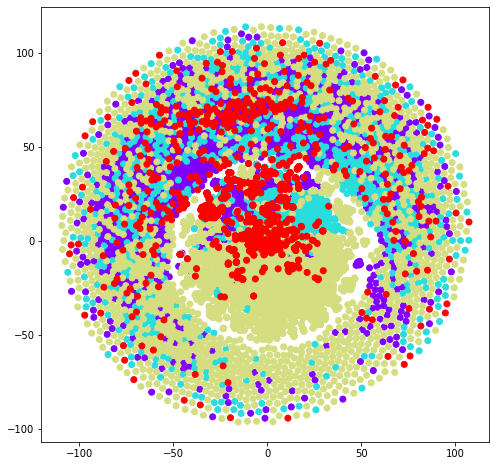

In [12]:
plt.figure(figsize=(10,8))
plt.axes().set(aspect='equal')
plt.scatter(x,y,c=y_train,cmap='rainbow')
plt.show()

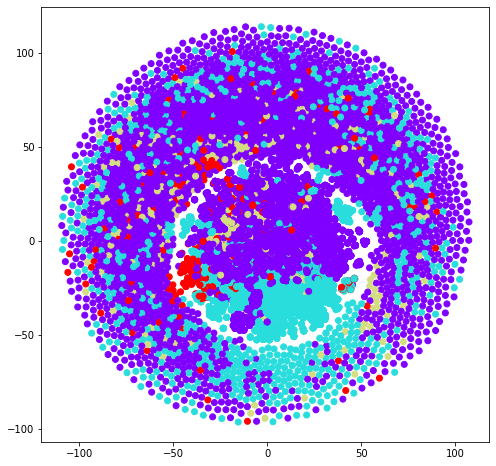

In [13]:
plt.figure(figsize=(10,8))
plt.axes().set(aspect='equal')
plt.scatter(x,y,c=kmean.labels_,cmap='rainbow')
plt.show()

##Task - 3

In [18]:
def func(txt):
    def punc(txt):
        for ch in string.punctuation:
            txt = txt.replace(ch,f" ")
        return txt
    def stem(txt):
        words = word_tokenize(txt)
        lst = []
        ps = PorterStemmer()
        for w in words:
            w = spell(w)
            lst.append(ps.stem(w))
        return " ".join(lst)
    
    def stop(txt):
        for ch in stop_words:
            if ch in txt:
                txt = txt.replace(ch," ")
        return txt
    
    txt = punc(txt)
    txt = stem(txt)
    txt = stop(txt)
    txt = re.sub(' +', ' ', txt)

    return txt

In [23]:
for i in range(10):
    i = random.randint(0,len(train_text))
    print(train_text[i])
    print(func(train_text[i]))
    print()

1355 e . 9 chfer guge er
1355 e 9 c r huge er

cung l . 16 z c
 ung l 16 z c

01 - 24309281e1 gr 23 . 574 x 102 x 40 / 50 bfeng cph42843
01 24309281e1 gr 23 574 x 102 x 40 50 feng cph42843

l - 1158 p - - 006037
l 1158 p 006037

99999999 - p örung v 02 . 02 . 2017 fquenzurc . nezung urc er
99999999 p örung v 02 02 2017 fquenzurc neburg url er

1 - 45° jw . cplee : e nclue e fr jw e r jw , 45° e hghx12 10 `` `` we clpng hrw . er per cung
1 45° jw c le e clue e fr jw e r jw 45° e h gh12 10 cl ng hrw er per ung

cvr re 150 p k
cvr 150 p k

14e6157 157 xble
14e6157 157 bl

015 - 247056r pr cung un
015 247056r pr ung un

crp v & cr nl ervc fee
c v cr nl er c fee

